In [2]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

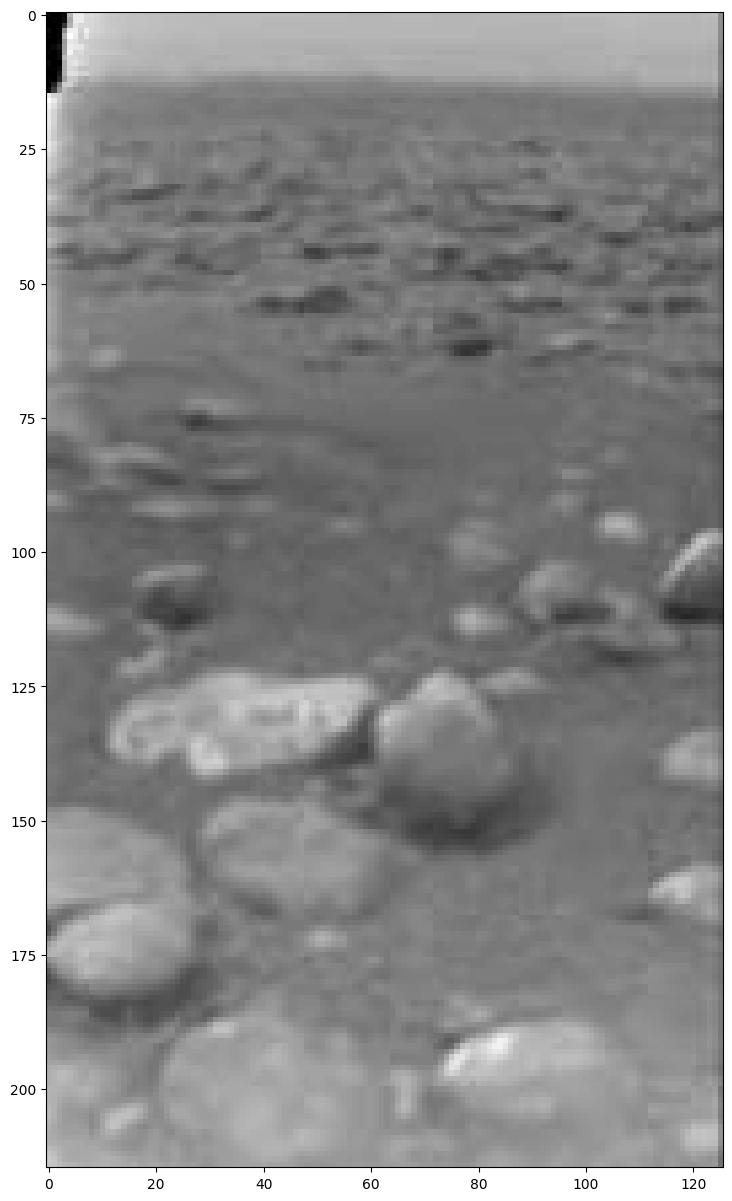

In [3]:
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt

titan = Image.open("titan.jpg")
titan_array = np.array(titan).astype(np.double)
tmax = titan_array.max()
tmin = titan_array.min()
titan_array = titan_array / tmax
titan_array.shape

plt.imshow(titan_array, cmap="gray")
plt.rcParams['figure.figsize'] = [20, 15]
plt.rcParams['figure.dpi'] = 100
plt.show()

tindex = np.arange(0, titan_array.shape[0]*titan_array.shape[1])
tp = 0.5
tindex_o = np.random.choice(tindex, size=round(tindex.shape[0]*tp), replace=False)
# Could do smarter sampling above, i.e. instead shuffle tindex as: np.random.shuffle(tindex)
# and then take the first round(tindex.shape[0]*tp) elements
# but setdiff1d seems like a good function to know about.
tindex_m = np.setdiff1d(tindex, tindex_o)